### Imports

In [4]:
import numpy as np
import cp2kdata
import json
import dpdata
import tensorflow
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Make CP2K Output Readable to DeepMDKit

In [20]:
cp2kmd_dir = "cp2k-data"
cp2kmd_output_name = "cp2k-test.log"
cp2kdata = dpdata.LabeledSystem(cp2kmd_dir, cp2k_output_name=cp2kmd_output_name, fmt="cp2kdata/md")
print(cp2kdata)

CP2KDATA| Virial Parsing using cp2kdata as plug in for dpdata was not multiplied by volume before cp2kdata v0.6.4 please check the cp2kdata version and the virial.npy


Data Summary
Labeled System
-------------------
Frame Numbers      : 101
Atom Numbers       : 200
Including Virials  : Yes
Element List       :
-------------------
Na  Cl
100  100


## Slit Data into Training and Validation Sets

In [23]:
index_validation = np.random.choice(len(cp2kdata), 10, replace=False)
index_training = list(set(range(len(cp2kdata))) - set(index_validation))
data_training = cp2kdata.sub_system(index_training)
data_validation = cp2kdata.sub_system(index_validation)
data_training.to_deepmd_npy("training_data")
data_validation.to_deepmd_npy("validation_data")

In [29]:
#making a directory to store my input script in
!mkdir train

mkdir: train: File exists


In [43]:
config_data = {
  
  "_comment1": " model parameters",
  "model": {
    "type_map": [
      "Na",
      "Cl"
    ],
    "descriptor": {
      "type": "se_e2_a",
      "sel": [
        100,
        100
      ],
      "rcut_smth": 0.50,
      "rcut": 6.00,
      "neuron": [
        10,
        20,
        40
      ],
      "resnet_dt": True,
      "axis_neuron": 4,
      "seed": 1,
      "_comment2": " that's all"
    },
    "fitting_net": {
      "neuron": [
        100,
        100,
        100
      ],
      "resnet_dt": True,
      "seed": 1,
      "_comment3": " that's all"
    },
    "_comment4": " that's all"
  },

  "learning_rate": {
    "type": "exp",
    "decay_steps": 5000,
    "start_lr": 0.001,
    "stop_lr": 3.51e-8,
    "_comment5": "that's all"
  },

  "loss": {
    "type": "ener",
    "start_pref_e": 0.02,
    "limit_pref_e": 1,
    "start_pref_f": 1000,
    "limit_pref_f": 1,
    "start_pref_v": 0,
    "limit_pref_v": 0,
    "_comment6": " that's all"
  },

  "training": {
    "training_data": {
      "systems": [
          "training_data"
      ],
      "batch_size": "auto",
      "_comment7": "that's all"
    },
    "validation_data": {
      "systems": [
        "validation_data"
      ],
      "batch_size": "auto",
      "numb_btch": 3,
      "_comment8": "that's all"
    },
    "numb_steps": 10000,
    "seed": 10,
    "disp_file": "lcurve.out",
    "disp_freq": 100,
    "save_freq": 1000,
    "_comment9": "that's all"
  },

  "_comment10": "that's all"
}

with open('train/input.json', 'w') as json_file:
    json.dump(config_data, json_file, indent=2)


In [45]:
!dp train train/input.json -l train/train.log

Instructions for updating:
non-resource variables are not supported in the long term
{'loss_dict', 'learning_rate_dict', 'loss', 'model', '$schema', 'nvnmd', 'learning_rate', 'training'}
{'type_map', 'fitting_net', 'data_stat_protect', 'sw_rmin', 'sw_rmax', 'spin', 'modifier', 'srtab_add_bias', 'type_embedding', 'data_bias_nsample', 'use_srtab', '$schema', 'type', 'smin_alpha', 'data_stat_nbatch', 'descriptor', 'compress'}
{'type_one_side', 'axis_neuron', 'trainable', 'resnet_dt', 'sel', 'seed', 'rcut', 'precision', 'set_davg_zero', '$schema', 'rcut_smth', 'type', 'exclude_types', 'neuron', 'activation_function'}
{'trainable', 'numb_fparam', 'numb_aparam', 'resnet_dt', 'layer_name', 'seed', 'atom_ener', 'use_aparam_as_mask', 'precision', '$schema', 'type', 'neuron', 'rcond', 'activation_function'}
{'stop_lr', 'start_lr', 'decay_steps', '$schema', 'type', 'scale_by_worker'}
{'start_pref_f', 'start_pref_pf', 'start_pref_e', 'start_pref_ae', 'limit_pref_e', 'enable_atom_ener_coeff', 'star

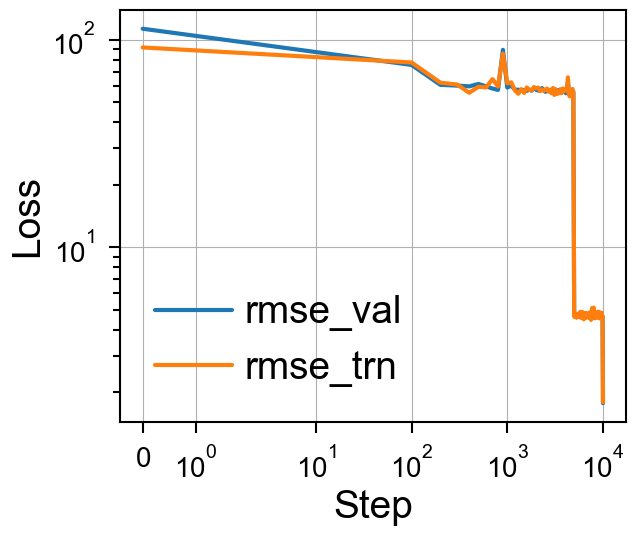

In [47]:
data = np.genfromtxt("lcurve.out", names=True)
for name in data.dtype.names[1:3]:
    plt.plot(data['step'], data[name], label=name)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.xscale('symlog')
plt.yscale('log')
plt.grid()
plt.show()

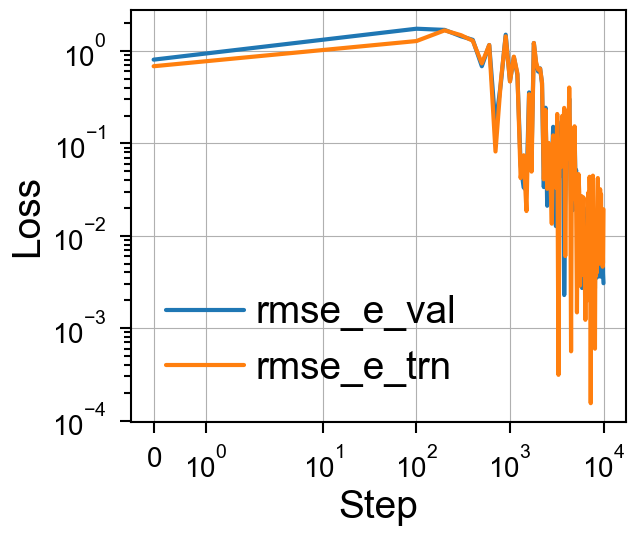

In [49]:
data = np.genfromtxt("lcurve.out", names=True)
for name in data.dtype.names[3:5]:
    plt.plot(data['step'], data[name], label=name)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.xscale('symlog')
plt.yscale('log')
plt.grid()
plt.show()

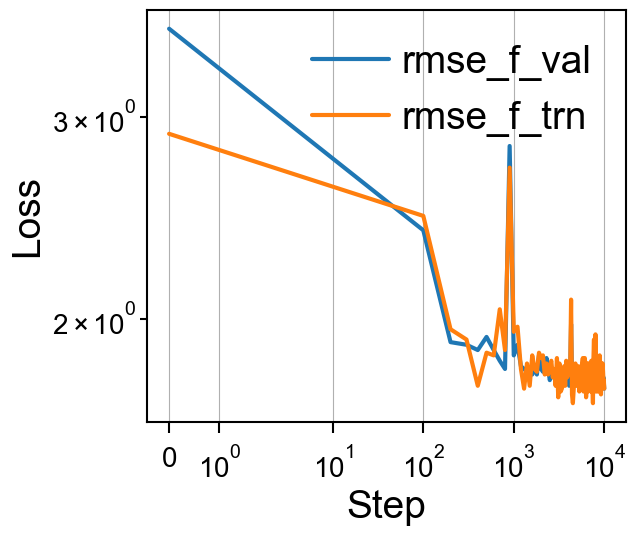

In [51]:
data = np.genfromtxt("lcurve.out", names=True)
for name in data.dtype.names[5:7]:
    plt.plot(data['step'], data[name], label=name)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.xscale('symlog')
plt.yscale('log')
plt.grid()
plt.show()

In [35]:
#all simulations 
#fully fit a model on simple nacl data
#try to run in lammps 

In [53]:
!dp freeze -o frozen_model.pb

Instructions for updating:
non-resource variables are not supported in the long term
I0000 00:00:1733510335.980041 42559568 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
DEEPMD INFO    The following nodes will be frozen: ['fitting_attr/dfparam', 'train_attr/min_nbor_dist', 'o_atom_virial', 'descrpt_attr/ntypes', 'o_energy', 'model_attr/model_type', 'model_attr/model_version', 't_mesh', 'o_atom_energy', 'o_force', 'fitting_attr/daparam', 'o_virial', 'descrpt_attr/rcut', 'model_attr/tmap', 'train_attr/training_script', 'model_type']
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https:/

## Test your Model

In [60]:
!dp test -m frozen_model.pb -s validation_data -n 10 -d results

Instructions for updating:
non-resource variables are not supported in the long term
I0000 00:00:1733510500.213166 42562021 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
DEEPMD INFO    # ---------------output of dp test--------------- 
DEEPMD INFO    # testing system : validation_data
DEEPMD INFO    # number of test data : 10 
DEEPMD INFO    Energy MAE         : 2.105354e+00 eV
DEEPMD INFO    Energy RMSE        : 2.794440e+00 eV
DEEPMD INFO    Energy MAE/Natoms  : 1.052677e-02 eV
DEEPMD INFO    Energy RMSE/Natoms : 1.397220e-02 eV
DEEPMD INFO    Force  MAE         : 1.189852e+00 eV/A
DEEPMD INFO    Force  RMSE        : 1.770784e+00 eV/A
DEEPMD INFO    Virial MAE         : 1.620324e+01 eV
DEEPMD INFO    Virial RMSE        : 2.542680e+01 eV
DEEPMD INFO    Virial MAE/Natoms  : 8.101621e-02 eV
DEEPM

In [18]:
e_per_atom = np.loadtxt("results.e_peratom.out")
f = np.loadtxt("results.f.out")

Text(0.5, 1.0, 'Energy Accuracy')

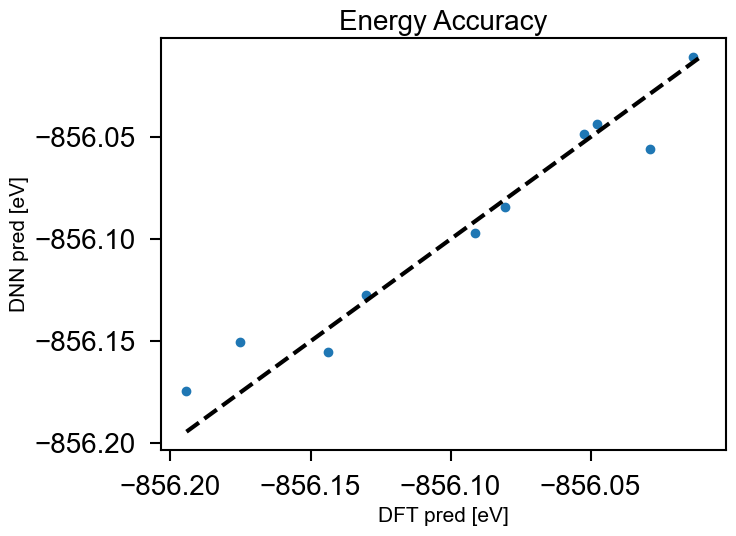

In [12]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_ylabel('DNN pred [eV]', fontsize=15)
ax.set_xlabel('DFT pred [eV]', fontsize=15)

ax.scatter(e_per_atom[:,0], e_per_atom[:,1])
ax.plot([np.min(e_per_atom), np.max(e_per_atom)],[np.min(e_per_atom), np.max(e_per_atom)], '--', color='black')

ax.set_title('Energy Accuracy', fontsize=20)

Text(0.5, 1.0, 'Force Accuracy')

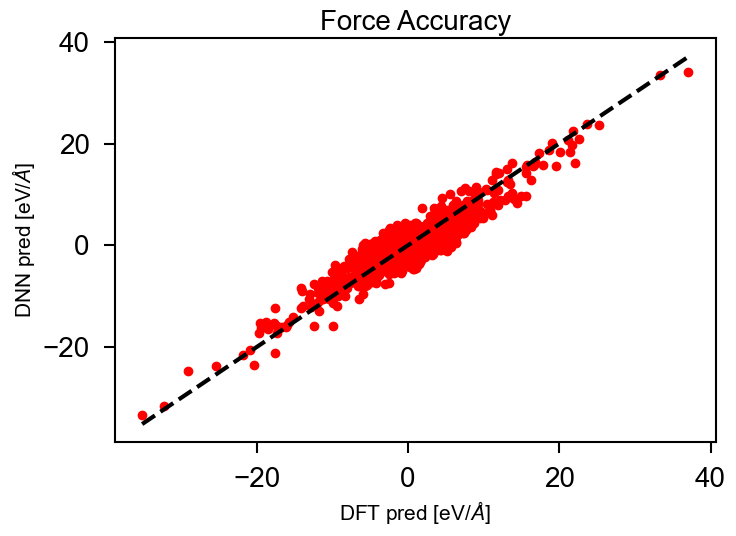

In [20]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_ylabel('DNN pred [eV/$\AA$]', fontsize=15)
ax.set_xlabel('DFT pred [eV/$\AA$]', fontsize=15)

ax.scatter(f[:,:3], f[:,3:], color='red')
ax.plot([np.min(f), np.max(f)],[np.min(f), np.max(f)], '--', color='black')

ax.set_title('Force Accuracy', fontsize=20)